In [3]:
require 'torch'

os.execute('wget -c http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz')
os.execute('tar -xvf cifar-10-binary.tar.gz')
local function convertCifar10BinToTorchTensor(inputFnames, outputFname)
   local nSamples = 0
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      assert(nSamplesF == math.floor(nSamplesF), 'expecting numSamples to be an exact integer')
      nSamples = nSamples + nSamplesF
      m:close()
   end

   local label = torch.ByteTensor(nSamples)
   local data = torch.ByteTensor(nSamples, 3, 32, 32)

   local index = 1
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      m:seek(1)
      for j=1,nSamplesF do
         label[index] = m:readByte()
         local store = m:readByte(3072)
         data[index]:copy(torch.ByteTensor(store))
         index = index + 1
      end
      m:close()
   end

   local out = {}
   out.data = data
   out.label = label
   print(out)
   torch.save(outputFname, out)
end

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/data_batch_1.bin',
                                'cifar-10-batches-bin/data_batch_2.bin',
                                'cifar-10-batches-bin/data_batch_3.bin',
                                'cifar-10-batches-bin/data_batch_4.bin',
                                'cifar-10-batches-bin/data_batch_5.bin'},
   'cifar10-train.t7')

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/test_batch.bin'},
   'cifar10-test.t7')

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin


cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin


cifar-10-batches-bin/data_batch_4.bin


cifar-10-batches-bin/test_batch.bin


cifar-10-batches-bin/readme.html


cifar-10-batches-bin/data_batch_5.bin


cifar-10-batches-bin/data_batch_2.bin


{
  data : ByteTensor - size: 50000x3x32x32
  label : ByteTensor - size: 50000
}


{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [4]:
require 'nn';
require 'paths'
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [5]:
trainset.label = trainset.label+1
testset.label = testset.label+1

In [6]:
-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(testset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
testset.data = testset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function testset:size() 
    return self.data:size(1) 
end

In [7]:
r = trainset.data[{ {}, {1}, {}, {}  }]*0.2989
g = trainset.data[{ {}, {2}, {}, {}  }]*0.5870
b = trainset.data[{ {}, {3}, {}, {}  }]*0.1140
trainset.data = r+g+b
r = testset.data[{ {}, {1}, {}, {}  }]*0.2989
g = testset.data[{ {}, {2}, {}, {}  }]*0.5870
b = testset.data[{ {}, {3}, {}, {}  }]*0.1140
testset.data = r+g+b

In [8]:
trainset.data = trainset.data/255
testset.data = testset.data/255

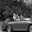

automobile	
2	


horse	
8	


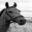

In [9]:
itorch.image(trainset.data[100]) -- display the 100-th image in dataset
print(classes[trainset.label[100]])
print(trainset.label[100])
itorch.image(testset.data[100]) -- display the 100-th image in dataset
print(classes[testset.label[100]])
print(testset.label[100])

In [10]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax(1)) 

In [11]:
criterion = nn.ClassNLLCriterion()

In [12]:
require 'cunn';
require 'cutorch';
cutorch.setDevice(2)
print(cutorch.getDevice())

2	


In [13]:
net = net:cuda()

In [14]:
criterion = criterion:cuda()

In [15]:
targets=trainset.label:long()
one_hot_train = torch.eye(10):index(1, targets)
--targets=testset.label:long()
--one_hot_test = torch.eye(10):index(1, targets)

In [16]:
trainset.data = trainset.data:cuda()
--trainset.label = one_hot_train:cuda()
trainset.label = trainset.label:cuda()
testset.data = testset.data:cuda()
testset.label = testset.label:cuda()

In [17]:
parameters, gradParameters = net:getParameters()

In [18]:
dl = require 'dataload'
optim = require 'optim';

train_loss={}
train_acc={}
test_loss={}
test_acc={}
function eval_train(epoch)
    local correct = 0
    local loss = 0
    local predictions = net:forward(trainset.data)
    local ll=criterion:forward(predictions, trainset.label)
    
    for i=1,10000 do
        local groundtruth = trainset.label[i]
        local prediction = predictions[i]
        -- loss = loss + ll[i]
        local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
        if groundtruth == indices[1] then
            correct = correct + 1
        end
    end
    --train_loss[epoch]=loss/10000
    train_loss[epoch]=ll
    train_acc[epoch]=correct/10000
    print('Train loss :' .. train_loss[epoch])
    print('Train Accuracy :' ,correct, 100*train_acc[epoch] .. ' % ')
end
function eval_test(epoch)
    local correct = 0
    local loss = 0
    local predictions = net:forward(testset.data)
    local ll=criterion:forward(predictions, testset.label)

    for i=1,10000 do
        local prediction = predictions[i]
        local groundtruth = testset.label[i]
        --loss = loss + ll[i]
        local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
        if groundtruth == indices[1] then
            correct = correct + 1
        end
    end
    --test_loss[epoch]=loss/10000
    test_loss[epoch]=ll
    test_acc[epoch]=correct/10000
    print('Test loss :' ..test_loss[epoch])
    print('Test Accuracy', correct, 100*test_acc[epoch] .. ' % ')
end

In [19]:

one_hot = torch.eye(10):index(1, targets)
dataloader = dl.TensorLoader(trainset.data, trainset.label)
i=0
batch_size=1000
epochs=100

-- Define SGD parameters.
sgd_params = {
    learningRate = 0.1,
    weightDecay = 0,
    momentum = 0.5
}
tstart=os.time()

for j=1,epochs do
    print("------ epoch - " ..j.. " ----- ")
    tot_loss=0
    for k, inputs, targets in dataloader:subiter(batch_size,50000) do
        -- Define a closure that computes the loss and dloss/dx.
        feval = function()
            -- reset gradients
            gradParameters:zero()
            output=net:forward(inputs)
            loss=criterion:forward(output, targets)
            gradients = criterion:backward(output, targets)
            net:backward(inputs, gradients)
            return loss, gradParameters
        end
        _,local_loss = optim.sgd(feval, parameters, sgd_params)
        ---tot_loss = tot_loss + local_loss[1]
    end
    eval_train(j)
    eval_test(j)
    ---print("------- loss - " ..(tot_loss/50).. " ------ ")
end

tend=os.time()
print("------ Time taken :",os.difftime (tend , tstart))

------ epoch - 1 ----- 	


Train loss :2.3027191162109	
Train Accuracy :	974	9.74 % 	


Test loss :2.3027155399323	
Test Accuracy	1000	10 % 	
------ epoch - 2 ----- 	


Train loss :2.3018841743469	
Train Accuracy :	974	9.74 % 	


Test loss :2.3018856048584	
Test Accuracy	1000	10 % 	
------ epoch - 3 ----- 	


Train loss :2.3012630939484	
Train Accuracy :	975	9.75 % 	


Test loss :2.3012685775757	
Test Accuracy	1000	10 % 	
------ epoch - 4 ----- 	


Train loss :2.3004014492035	
Train Accuracy :	1063	10.63 % 	


Test loss :2.3004190921783	
Test Accuracy	1081	10.81 % 	
------ epoch - 5 ----- 	


Train loss :2.299008846283	
Train Accuracy :	1414	14.14 % 	


Test loss :2.2990400791168	
Test Accuracy	1455	14.55 % 	
------ epoch - 6 ----- 	


Train loss :2.2961065769196	
Train Accuracy :	1538	15.38 % 	


Test loss :2.2961595058441	
Test Accuracy	1534	15.34 % 	
------ epoch - 7 ----- 	


Train loss :2.2894208431244	
Train Accuracy :	1698	16.98 % 	


Test loss :2.2895109653473	
Test Accuracy	1714	17.14 % 	
------ epoch - 8 ----- 	


Train loss :2.2671687602997	
Train Accuracy :	1747	17.47 % 	


Test loss :2.2673389911652	
Test Accuracy	1746	17.46 % 	
------ epoch - 9 ----- 	


Train loss :2.1914064884186	
Train Accuracy :	1910	19.1 % 	


Test loss :2.1910812854767	
Test Accuracy	1941	19.41 % 	
------ epoch - 10 ----- 	


Train loss :2.1252851486206	
Train Accuracy :	2249	22.49 % 	


Test loss :2.1246776580811	
Test Accuracy	2210	22.1 % 	
------ epoch - 11 ----- 	


Train loss :2.0788753032684	
Train Accuracy :	2471	24.71 % 	


Test loss :2.0785295963287	
Test Accuracy	2460	24.6 % 	
------ epoch - 12 ----- 	


Train loss :2.268833398819	
Train Accuracy :	1481	14.81 % 	


Test loss :2.2676870822906	
Test Accuracy	1476	14.76 % 	
------ epoch - 13 ----- 	


Train loss :2.0446004867554	
Train Accuracy :	2531	25.31 % 	


Test loss :2.0460481643677	
Test Accuracy	2545	25.45 % 	
------ epoch - 14 ----- 	


Train loss :2.0507884025574	
Train Accuracy :	2548	25.48 % 	


Test loss :2.0541441440582	
Test Accuracy	2543	25.43 % 	
------ epoch - 15 ----- 	


Train loss :1.9773544073105	
Train Accuracy :	2760	27.6 % 	


Test loss :1.982360959053	
Test Accuracy	2741	27.41 % 	
------ epoch - 16 ----- 	


Train loss :1.9340188503265	
Train Accuracy :	2956	29.56 % 	


Test loss :1.9404596090317	
Test Accuracy	2917	29.17 % 	
------ epoch - 17 ----- 	


Train loss :1.9151613712311	
Train Accuracy :	3083	30.83 % 	


Test loss :1.922572016716	
Test Accuracy	3027	30.27 % 	
------ epoch - 18 ----- 	


Train loss :1.8255916833878	
Train Accuracy :	3406	34.06 % 	


Test loss :1.8325556516647	
Test Accuracy	3347	33.47 % 	
------ epoch - 19 ----- 	


Train loss :1.8320891857147	
Train Accuracy :	3464	34.64 % 	


Test loss :1.8405640125275	
Test Accuracy	3336	33.36 % 	
------ epoch - 20 ----- 	


Train loss :1.7706813812256	
Train Accuracy :	3646	36.46 % 	


Test loss :1.7790677547455	
Test Accuracy	3525	35.25 % 	
------ epoch - 21 ----- 	


Train loss :1.8357092142105	
Train Accuracy :	3476	34.76 % 	


Test loss :1.8466771841049	
Test Accuracy	3395	33.95 % 	


------ epoch - 22 ----- 	


Train loss :1.7375901937485	
Train Accuracy :	3786	37.86 % 	


Test loss :1.7489671707153	
Test Accuracy	3691	36.91 % 	
------ epoch - 23 ----- 	


Train loss :1.7068822383881	
Train Accuracy :	3867	38.67 % 	


Test loss :1.7186037302017	
Test Accuracy	3762	37.62 % 	
------ epoch - 24 ----- 	


Train loss :1.8433481454849	
Train Accuracy :	3504	35.04 % 	


Test loss :1.8583668470383	
Test Accuracy	3469	34.69 % 	
------ epoch - 25 ----- 	


Train loss :1.6794853210449	
Train Accuracy :	3972	39.72 % 	


Test loss :1.6940740346909	
Test Accuracy	3849	38.49 % 	
------ epoch - 26 ----- 	


Train loss :1.7958999872208	
Train Accuracy :	3671	36.71 % 	


Test loss :1.813645362854	
Test Accuracy	3608	36.08 % 	
------ epoch - 27 ----- 	


Train loss :1.6248395442963	
Train Accuracy :	4213	42.13 % 	


Test loss :1.6443115472794	
Test Accuracy	4078	40.78 % 	
------ epoch - 28 ----- 	


Train loss :1.6769418716431	
Train Accuracy :	4015	40.15 % 	


Test loss :1.6938273906708	
Test Accuracy	3886	38.86 % 	
------ epoch - 29 ----- 	


Train loss :1.6213546991348	
Train Accuracy :	4238	42.38 % 	


Test loss :1.6425607204437	
Test Accuracy	4114	41.14 % 	
------ epoch - 30 ----- 	


Train loss :1.5632338523865	
Train Accuracy :	4413	44.13 % 	


Test loss :1.5925838947296	
Test Accuracy	4221	42.21 % 	
------ epoch - 31 ----- 	


Train loss :1.5685560703278	
Train Accuracy :	4422	44.22 % 	


Test loss :1.5986832380295	
Test Accuracy	4251	42.51 % 	
------ epoch - 32 ----- 	


Train loss :1.5237175226212	
Train Accuracy :	4600	46 % 	


Test loss :1.5602514743805	
Test Accuracy	4385	43.85 % 	
------ epoch - 33 ----- 	


Train loss :1.4995419979095	
Train Accuracy :	4685	46.85 % 	


Test loss :1.5406984090805	
Test Accuracy	4467	44.67 % 	
------ epoch - 34 ----- 	


Train loss :1.4722526073456	
Train Accuracy :	4796	47.96 % 	


Test loss :1.5177887678146	
Test Accuracy	4594	45.94 % 	
------ epoch - 35 ----- 	


Train loss :1.4679315090179	
Train Accuracy :	4792	47.92 % 	


Test loss :1.5164903402328	
Test Accuracy	4574	45.74 % 	
------ epoch - 36 ----- 	


Train loss :1.4502984285355	
Train Accuracy :	4882	48.82 % 	


Test loss :1.5026487112045	
Test Accuracy	4643	46.43 % 	
------ epoch - 37 ----- 	


Train loss :1.4292786121368	
Train Accuracy :	4930	49.3 % 	


Test loss :1.4860293865204	
Test Accuracy	4705	47.05 % 	
------ epoch - 38 ----- 	


Train loss :1.4068131446838	
Train Accuracy :	5010	50.1 % 	


Test loss :1.4676203727722	
Test Accuracy	4823	48.23 % 	
------ epoch - 39 ----- 	


Train loss :1.4037199020386	
Train Accuracy :	5044	50.44 % 	


Test loss :1.4684436321259	
Test Accuracy	4788	47.88 % 	
------ epoch - 40 ----- 	


Train loss :1.3937624692917	
Train Accuracy :	5094	50.94 % 	


Test loss :1.4617609977722	
Test Accuracy	4857	48.57 % 	
------ epoch - 41 ----- 	


Train loss :1.3827078342438	
Train Accuracy :	5175	51.75 % 	


Test loss :1.4540256261826	
Test Accuracy	4866	48.66 % 	
------ epoch - 42 ----- 	


Train loss :1.3722027540207	
Train Accuracy :	5197	51.97 % 	


Test loss :1.4479478597641	
Test Accuracy	4891	48.91 % 	
------ epoch - 43 ----- 	


Train loss :1.346221446991	
Train Accuracy :	5337	53.37 % 	


Test loss :1.4265753030777	
Test Accuracy	4976	49.76 % 	
------ epoch - 44 ----- 	


Train loss :1.3091216087341	
Train Accuracy :	5477	54.77 % 	


Test loss :1.3957425355911	
Test Accuracy	5097	50.97 % 	
------ epoch - 45 ----- 	


Train loss :1.3112326860428	
Train Accuracy :	5472	54.72 % 	


Test loss :1.4000104665756	
Test Accuracy	5069	50.69 % 	
------ epoch - 46 ----- 	


Train loss :1.3005572557449	
Train Accuracy :	5498	54.98 % 	


Test loss :1.3933717012405	
Test Accuracy	5127	51.27 % 	
------ epoch - 47 ----- 	


Train loss :1.2746829986572	
Train Accuracy :	5630	56.3 % 	


Test loss :1.373304605484	
Test Accuracy	5194	51.94 % 	
------ epoch - 48 ----- 	


Train loss :1.2570682764053	
Train Accuracy :	

5699	56.99 % 	


Test loss :1.3614186048508	
Test Accuracy	5221	52.21 % 	
------ epoch - 49 ----- 	


Train loss :1.2638515233994	
Train Accuracy :	5652	56.52 % 	


Test loss :1.368990778923	
Test Accuracy	5178	51.78 % 	
------ epoch - 50 ----- 	


Train loss :1.2327289581299	
Train Accuracy :	5781	57.81 % 	


Test loss :1.3466057777405	
Test Accuracy	5275	52.75 % 	
------ epoch - 51 ----- 	


Train loss :1.2396075725555	
Train Accuracy :	5720	57.2 % 	


Test loss :1.355477809906	
Test Accuracy	5240	52.4 % 	
------ epoch - 52 ----- 	


Train loss :1.2173401117325	
Train Accuracy :	5797	57.97 % 	


Test loss :1.3415908813477	
Test Accuracy	5319	53.19 % 	
------ epoch - 53 ----- 	


Train loss :1.2020218372345	
Train Accuracy :	5858	58.58 % 	


Test loss :1.3300853967667	
Test Accuracy	5355	53.55 % 	
------ epoch - 54 ----- 	


Train loss :1.2250835895538	
Train Accuracy :	5768	57.68 % 	


Test loss :1.3550684452057	
Test Accuracy	5303	53.03 % 	


------ epoch - 55 ----- 	


Train loss :1.1851263046265	
Train Accuracy :	5921	59.21 % 	


Test loss :1.3237665891647	
Test Accuracy	5380	53.8 % 	
------ epoch - 56 ----- 	


Train loss :1.17318379879	
Train Accuracy :	5950	59.5 % 	


Test loss :1.3190894126892	
Test Accuracy	5417	54.17 % 	
------ epoch - 57 ----- 	


Train loss :1.1599016189575	
Train Accuracy :	6005	60.05 % 	


Test loss :1.3093626499176	
Test Accuracy	5477	54.77 % 	
------ epoch - 58 ----- 	


Train loss :1.1760448217392	
Train Accuracy :	5977	59.77 % 	


Test loss :1.3333072662354	
Test Accuracy	5380	53.8 % 	
------ epoch - 59 ----- 	


Train loss :1.1271241903305	
Train Accuracy :	6137	61.37 % 	


Test loss :1.2894294261932	
Test Accuracy	5518	55.18 % 	
------ epoch - 60 ----- 	


Train loss :1.1399520635605	
Train Accuracy :	6097	60.97 % 	


Test loss :1.3069688081741	
Test Accuracy	5512	55.12 % 	
------ epoch - 61 ----- 	


Train loss :1.1224049329758	
Train Accuracy :	6149	61.49 % 	


Test loss :1.2964442968369	
Test Accuracy	5522	55.22 % 	
------ epoch - 62 ----- 	


Train loss :1.1162377595901	
Train Accuracy :	6170	61.7 % 	


Test loss :1.2955317497253	
Test Accuracy	5510	55.1 % 	
------ epoch - 63 ----- 	


Train loss :1.0786309242249	
Train Accuracy :	6308	63.08 % 	


Test loss :1.2651352882385	
Test Accuracy	5641	56.41 % 	
------ epoch - 64 ----- 	


Train loss :1.077063202858	
Train Accuracy :	6353	63.53 % 	


Test loss :1.2701056003571	
Test Accuracy	5616	56.16 % 	
------ epoch - 65 ----- 	


Train loss :1.0745723247528	
Train Accuracy :	6356	63.56 % 	


Test loss :1.2713793516159	
Test Accuracy	5638	56.38 % 	
------ epoch - 66 ----- 	


Train loss :1.0719760656357	
Train Accuracy :	6338	63.38 % 	


Test loss :1.2763235569	
Test Accuracy	5605	56.05 % 	
------ epoch - 67 ----- 	


Train loss :1.0495764017105	
Train Accuracy :	

6431	64.31 % 	


Test loss :1.2615375518799	
Test Accuracy	5678	56.78 % 	
------ epoch - 68 ----- 	


Train loss :1.0426602363586	
Train Accuracy :	6455	64.55 % 	


Test loss :1.2612451314926	
Test Accuracy	5678	56.78 % 	
------ epoch - 69 ----- 	


Train loss :1.0278517007828	
Train Accuracy :	6470	64.7 % 	


Test loss :1.2528458833694	
Test Accuracy	5706	57.06 % 	
------ epoch - 70 ----- 	


Train loss :1.0344178676605	
Train Accuracy :	6474	64.74 % 	


Test loss :1.265137553215	
Test Accuracy	5690	56.9 % 	
------ epoch - 71 ----- 	


Train loss :1.0238521099091	
Train Accuracy :	6510	65.1 % 	


Test loss :1.2599130868912	
Test Accuracy	5690	56.9 % 	
------ epoch - 72 ----- 	


Train loss :1.0180447101593	
Train Accuracy :	6512	65.12 % 	


Test loss :1.2657210826874	
Test Accuracy	5694	56.94 % 	
------ epoch - 73 ----- 	


Train loss :0.99585741758347	
Train Accuracy :	6579	65.79 % 	


Test loss :1.2518215179443	
Test Accuracy	5751	57.51 % 	
------ epoch - 74 ----- 	


Train loss :1.0171359777451	
Train Accuracy :	6499	64.99 % 	


Test loss :1.2720264196396	
Test Accuracy	5686	56.86 % 	
------ epoch - 75 ----- 	


Train loss :1.0017927885056	
Train Accuracy :	6554	65.54 % 	


Test loss :1.2676995992661	
Test Accuracy	5700	57 % 	
------ epoch - 76 ----- 	


Train loss :0.99209630489349	
Train Accuracy :	6574	65.74 % 	


Test loss :1.2673114538193	
Test Accuracy	5687	56.87 % 	
------ epoch - 77 ----- 	


Train loss :0.98230296373367	
Train Accuracy :	6611	66.11 % 	


Test loss :1.2642760276794	
Test Accuracy	5706	57.06 % 	
------ epoch - 78 ----- 	


Train loss :0.98245966434479	
Train Accuracy :	6606	66.06 % 	


Test loss :1.2737337350845	
Test Accuracy	5709	57.09 % 	
------ epoch - 79 ----- 	


Train loss :0.95923578739166	
Train Accuracy :	6691	66.91 % 	


Test loss :1.2643340826035	
Test Accuracy	5737	57.37 % 	
------ epoch - 80 ----- 	


Train loss :0.96429115533829	
Train Accuracy :	6661	66.61 % 	


Test loss :1.2732847929001	
Test Accuracy	5719	57.19 % 	
------ epoch - 81 ----- 	


Train loss :0.94473415613174	
Train Accuracy :	6757	67.57 % 	


Test loss :1.2658414840698	
Test Accuracy	5745	57.45 % 	
------ epoch - 82 ----- 	


Train loss :0.96399903297424	
Train Accuracy :	6718	67.18 % 	


Test loss :1.2827504873276	
Test Accuracy	5698	56.98 % 	
------ epoch - 83 ----- 	

Train loss :0.93487703800201	
Train Accuracy :	6776	67.76 % 	


Test loss :1.2693767547607	
Test Accuracy	5753	57.53 % 	
------ epoch - 84 ----- 	


Train loss :0.91427344083786	
Train Accuracy :	6842	

68.42 % 	


Test loss :1.2563625574112	
Test Accuracy	5802	58.02 % 	
------ epoch - 85 ----- 	


Train loss :0.92034560441971	
Train Accuracy :	6810	68.1 % 	


Test loss :1.2662644386292	


Test Accuracy	5745	57.45 % 	
------ epoch - 86 ----- 	


Train loss :0.93806874752045	
Train Accuracy :	6733	67.33 % 	


Test loss :1.2935771942139	
Test Accuracy	5689	56.89 % 	
------ epoch - 87 ----- 	


Train loss :0.91185122728348	
Train Accuracy :	6827	68.27 % 	


Test loss :1.2782697677612	
Test Accuracy	5728	57.28 % 	
------ epoch - 88 ----- 	


Train loss :0.90512585639954	
Train Accuracy :	6883	68.83 % 	


Test loss :1.2778151035309	
Test Accuracy	5747	57.47 % 	
------ epoch - 89 ----- 	


Train loss :0.92829531431198	
Train Accuracy :	6754	67.54 % 	


Test loss :1.3122291564941	
Test Accuracy	5619	56.19 % 	
------ epoch - 90 ----- 	


Train loss :0.93357443809509	
Train Accuracy :	6774	67.74 % 	


Test loss :1.314457654953	
Test Accuracy	5666	56.66 % 	


------ epoch - 91 ----- 	


Train loss :0.96618288755417	
Train Accuracy :	6648	66.48 % 	


Test loss :1.363493680954	
Test Accuracy	5534	55.34 % 	
------ epoch - 92 ----- 	


Train loss :0.8864768743515	
Train Accuracy :	6927	69.27 % 	


Test loss :1.2939040660858	
Test Accuracy	5719	57.19 % 	
------ epoch - 93 ----- 	


Train loss :0.95534718036652	
Train Accuracy :	6696	66.96 % 	


Test loss :1.3689504861832	
Test Accuracy	5534	55.34 % 	
------ epoch - 94 ----- 	


Train loss :0.91157978773117	
Train Accuracy :	6862	68.62 % 	


Test loss :1.3298976421356	
Test Accuracy	5653	56.53 % 	
------ epoch - 95 ----- 	


Train loss :0.87512594461441	
Train Accuracy :	

6967	69.67 % 	


Test loss :1.3138011693954	
Test Accuracy	5680	56.8 % 	
------ epoch - 96 ----- 	


Train loss :0.9572691321373	
Train Accuracy :	6730	67.3 % 	


Test loss :1.3889111280441	
Test Accuracy	5527	55.27 % 	
------ epoch - 97 ----- 	


Train loss :0.92234396934509	
Train Accuracy :	6841	68.41 % 	


Test loss :1.362322807312	
Test Accuracy	5621	56.21 % 	
------ epoch - 98 ----- 	


Train loss :0.9625044465065	
Train Accuracy :	6715	67.15 % 	


Test loss :1.4065593481064	
Test Accuracy	5490	54.9 % 	
------ epoch - 99 ----- 	


Train loss :0.95573633909225	
Train Accuracy :	6725	67.25 % 	


Test loss :1.4174801111221	
Test Accuracy	5492	54.92 % 	
------ epoch - 100 ----- 	


Train loss :0.93409049510956	
Train Accuracy :	6795	67.95 % 	


Test loss :1.4017479419708	
Test Accuracy	5494	54.94 % 	
------ Time taken :	761	


In [21]:
Json = require("json")
-- Function to save a table.&nbsp; Since game settings need to be saved from session to session, we will
-- use the Documents Directory
function saveJSON(t, filename)
    local path = '/root/'..filename
    local file = io.open(path, "w")
    
    if file then
        local contents = Json.encode(t)
        file:write( contents )
        io.close( file )
        return true
    else
        return false
    end
end

In [22]:
saveJSON(train_acc, 'train_acc.json')
saveJSON(test_acc, 'test_acc.json')
saveJSON(train_loss, 'train_loss.json')
saveJSON(test_loss, 'test_loss.json')

In [28]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	54.6 %	
automobile	85.8 %	
bird	0 %	
cat	8.9 %	
deer	0 %	
dog	50.7 %	
frog	0 %	
horse	32.7 %	
ship	27.3 %	
truck	34.1 %	
